In [1]:
import numpy as np
import pandas as pd
import math
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from astropy.io import ascii

In [2]:
def ArnettFit(M_N,MejE,tstart):
    # constants
    M_sun = 2e33
    c = 3e10

    #params to fit:
    #E_K=3.3737988d+51
    #M_ej 3.1629364*M_sun
    # MejE = Mej^(3/4)*Ek^(-1/4)
    

    M_Ni = M_N*M_sun
    M_ejE_K = MejE*((M_sun)**3/(1e51))**(0.25)

    # time vector (sec)
    #dt = (np.arange(103.*4)/4.+0.25)*86400.
    dt = (np.arange(tstart,303, 0.25))*86400.

    beta=13.8 # constant of integration (Arnett 1982)
    k_opt=0.05 # g cm^-2 optical opacity

    tau_Ni=8.8*86400. # decay time of Ni56 in sec
    tau_Co=9.822e6 # decay time of Co56 in sec

    e_Ni=3.90e10 # erg/s/g energy produced by 1 gram of Ni
    e_Co=6.78e9 # erg/s/g energy produced by 1 gram of Co

    # tau_m is the timescale of the light-curve
    #tau_m_test=double(((k_opt/(beta*c))^0.5)*((10.*M_ej^3./(3.*E_K))^(0.25)))
    tau_m = (((k_opt/(beta*c))**0.5)*((10./3.)**(0.25))*M_ejE_K)

    # integrate up the A(z) factor where z goes from 0 to x
    int_A= np.zeros(len(dt))
    int_B= np.zeros(len(dt))
    L_ph= np.zeros(len(dt))

    x=(dt/tau_m)
    y=(tau_m/(2.*tau_Ni))
    s=(tau_m*(tau_Co-tau_Ni)/(2.*tau_Co*tau_Ni))

    for i in range(len(dt)):
        z = np.arange(100)*x[i]/100.
        Az = 2.*z*np.exp(-2.*z*y+z**2.)
        Bz = 2.*z*np.exp(-2.*z*y+2.*z*s+z**2.)
        int_A[i] = integrate.simps(Az,z)
        int_B[i] = integrate.simps(Bz,z)
        L_ph[i] = ((M_Ni*np.exp(-1.*x[i]**2.))*((e_Ni-e_Co)*int_A[i]+e_Co*int_B[i]))

       
    return dt, L_ph#data = (np.array(mni),np.array(mekej),t,np.array(lum))
                   
                   
#print(L_ph)
#print(dt)                 

;This function will output a late-time decay tail for radioactive
;nickel/cobalt. Input parameters are:
;tstart: time post explosion  (in days) when you want to start calculating.
;MNi: Nickel mass in units of solar masses.
;Fs: a parameter which will control the decay slope. In particular,
;it is related to what fraction of the gamma-rays can escape with out
;being thermalized. this is referred to as 'incomplete gamma-ray
;trapping'. In the Valenti paper where these equations were
;taken from, F = 32*Mej_sol/sqrt(Ek_51) where Mni_sol is the ejecta
;mass in units of solar masses and ek_51 is the kinetic energy in
;units of 10^51 ergs. So you can use that to determine a useful
;value. For example, reasonable values might range from 32 up to 320
;(Mej = 1-10 Msun; Ek = 10^51 ergs). In your case maybe higher? A
;smaller value of Fs will lead to a steeper decline slope.
  
;Note, that I have kept a flag here for 'fulltrap'. That means that it
;assumes full trapping of the gamma-rays---none of them escape. If you
;look below you see this is similar to setting Fs to be a very large
;number. Because in that case the exponenttial term in cobalt source
;terms below goes to 0. 
  

In [3]:
def ValentiNebFit(MNi,Fs,tstart,fulltrap=False):
  #variables
   # Mej_sol = 5  #1-10 solar masses
   # Ek_51 =  2e51  #1e51 ergs
   # Fs = (32*Mej_sol)/math.sqrt(Ek_51)
    #MNi = 2 # mass of nickel ranges from 0.1-2
    #tstart = 150

  #constants
    M_sun = 2e33
    c = 3e10
    tau_Ni = 8.8*86400  #decay time of Ni56 in sec
    tau_Co=9.822e6   #decay time of Co56 in sec
    e_Ni=3.90e10   # erg/s/g energy produced by 1 gram of Ni
    e_Co=6.78e9   #erg/s/g energy produced by 1 gram of Co
    
    
    #Parameters
    M_Ni = MNi*M_sun
    F = Fs
    G = 16.1*F

    # time vector in days starting at tstart days post-explosion.
    dt = (np.arange(tstart,500,1))#*86400.
    
#equations;;;;;;;;;;;;;;;;;

    #Nickel source term
    S_Ni = M_Ni*e_Ni*np.exp(-(dt*86400.)/tau_Ni)

    #Cobalt Source terms:
    Epsilon = M_Ni*e_Co*(np.exp(-(dt*86400.)/tau_Co) - np.exp(-(dt*86400.)/tau_Ni))

    S_Co1 = 0.81*Epsilon*(1-np.exp(-(F/dt)**2.))
    S_Co2 = 0.164*Epsilon*(1-np.exp(-(F/dt)**2.))*(1-np.exp(-(G/dt)**2.))
    S_Co3 = 0.036*Epsilon*(1-np.exp(-(G/dt)**2.))

    #Lum = np.zeros(len(dt))
    
    if fulltrap:
        S_Co1 = 0.81*Epsilon
        S_Co2 = 0.164*Epsilon
        S_Co3 = 0.036*Epsilon
    #Total Luminosity
    Lum = S_Ni + S_Co1 + S_Co2 + S_Co3  #This should be in erg/s
    
    return dt,Lum
    
#print(Lum)
#print(dt)    

In [34]:
file_out = 'Nickel2a-t.csv'
#data = [mni,mekej,t,lum]
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
tstart = 1
#lum = data1['lum']
Mni_p = np.linspace(0.5,20,20) # Nickel mass in solar mass units
Mekej_p = np.linspace(0.5,20,20) # Mekej between 0.5-2.5 for normal SNe
Lum_0 = data1['lum']
t_0 = data1['tgmax']+0.525965
#t_0 = data1['t']
mni = [] #Mass of nicke in solar mass
mekej =[] #mekej
t =[] #time
lum = [] #luminosity
RuledOut_g = []

for M_N in Mni_p:
    for MejE in Mekej_p:
        dt, L_ph = ArnettFit(M_N,MejE,tstart)
        
         #Evaluate if this mni and Mekej allowed:
        RuledOut = False #Assume a default position that this combination is allowed.
        Lum = np.interp(t_0, dt/86400, L_ph)
        #loop over the entire bol luminosity and rule out dataset where simulated is greater than bol lum
        for i in range(len(Lum_0)):
            time = t_0[i]
            Lumino = Lum_0[i]
        
            Lum_test1 = Lum[i]
            if (Lum_test1 > Lumino):
                RuledOut = True
                break
        mni.append(M_N)
        mekej.append(MejE) 
        t.append(dt/86400)
        lum.append(L_ph)
        RuledOut_g.append(RuledOut)
          
data = [mni,mekej,RuledOut_g]
names = ['Mni','Mekej','RuledOut']
ascii.write(data,file_out,names=names,overwrite=True)       


<ipython-input-2-8803c1a26bb5>:47: RuntimeWarning: overflow encountered in double_scalars
  L_ph[i] = ((M_Ni*np.exp(-1.*x[i]**2.))*((e_Ni-e_Co)*int_A[i]+e_Co*int_B[i]))
<ipython-input-2-8803c1a26bb5>:44: RuntimeWarning: overflow encountered in multiply
  Bz = 2.*z*np.exp(-2.*z*y+2.*z*s+z**2.)
<ipython-input-2-8803c1a26bb5>:44: RuntimeWarning: overflow encountered in exp
  Bz = 2.*z*np.exp(-2.*z*y+2.*z*s+z**2.)
<ipython-input-2-8803c1a26bb5>:43: RuntimeWarning: overflow encountered in multiply
  Az = 2.*z*np.exp(-2.*z*y+z**2.)
<ipython-input-2-8803c1a26bb5>:43: RuntimeWarning: overflow encountered in exp
  Az = 2.*z*np.exp(-2.*z*y+z**2.)
/Users/adaezeibik/anaconda3/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:516: RuntimeWarning: overflow encountered in multiply
  y[slice1] * (hsum *
<ipython-input-2-8803c1a26bb5>:47: RuntimeWarning: invalid value encountered in double_scalars
  L_ph[i] = ((M_Ni*np.exp(-1.*x[i]**2.))*((e_Ni-e_Co)*int_A[i]+e_Co*int_B[i]))


In [57]:
#Calculate rise_time at a given Mni and MejEk

file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
tstart = 1
#lum = data1['lum']
Mni_p = 5 #np.linspace(0.5,20,20) # Nickel mass in solar mass units
Mekej_p = 15 #np.linspace(0.5,20,20) # Mekej between 0.5-2.5 for normal SNe
Lum_0 = data1['lum']
t_0 = data1['tgmax']+0.525965
#t_0 = data1['t']
mni = [] #Mass of nicke in solar mass
mekej =[] #mekej
t =[] #time
lum = [] #luminosity
RuledOut_g = []

dt, L_ph = ArnettFit(Mni_p,Mekej_p,tstart)
Lum = np.interp(t_0, dt/86400, L_ph)

mni.append(M_N)
mekej.append(MejE) 
t.append(dt/86400)
lum.append(L_ph)
lum, t

([array([1.91048248e+40, 2.93951471e+40, 4.16854215e+40, ...,
         6.39023518e+42, 6.37376171e+42, 6.35732565e+42])],
 [array([  1.  ,   1.25,   1.5 , ..., 302.25, 302.5 , 302.75])])

In [59]:
a = max(lum[0])
#lum.index(a)
print("The index value of a is: ", np.where(lum[0] == max(lum[0])))
#a , lum[0][93], t[0][93] #rise_time = [24.25, 52,103.25,141, 172.5]   MejEk = [2.5,5,10,15, 20]
#a , lum[0][204], t[0][204] 
#a , lum[0][409], t[0][409]
#a , lum[0][560], t[0][560] 
#a , lum[0][686], t[0][686] 


The index value of a is:  (array([560]),)


(1.9053815772722272e+43, 1.9053815772722272e+43, 141.0)

In [ ]:
#for t
fig = plt.figure(figsize=(10.80,10.80))
plt.rcParams.update({'font.size': 40})
file_in = 'Nickel2a.csv'
data_plot = ascii.read(file_in)

mni = data_plot['Mni']
mej = data_plot['Mekej']

#plt.figure()

for i in range(len(data_plot)):
    if data_plot['RuledOut'][i] == 'True':
        plt.plot(mej[i],mni[i],'rs', alpha=0.4,ms = 20)
    else:
        plt.plot(mej[i],mni[i],'ks',alpha=0.2, ms=20)#,alpha=0.2
        
plt.text(2,1.9,'The red boxes are not allowed $t_{exp + 3}$', color = 'r',fontsize =25)
plt.text(3,1.6,'The gray boxes are allowed', color = 'k',fontsize =25)

plt.xlabel(r'$M^{3/4}/E^{1/4}$ (${M}_\odot$/$10^{-51}$)',fontsize =40)
plt.ylabel(r'Mni (${M}_\odot$)',fontsize =40)
plt.tick_params(labelsize=40)
#plt.legend(fontsize =20)
#fig.savefig('mni-mej1a.png',dpi = 300, transparent = True)

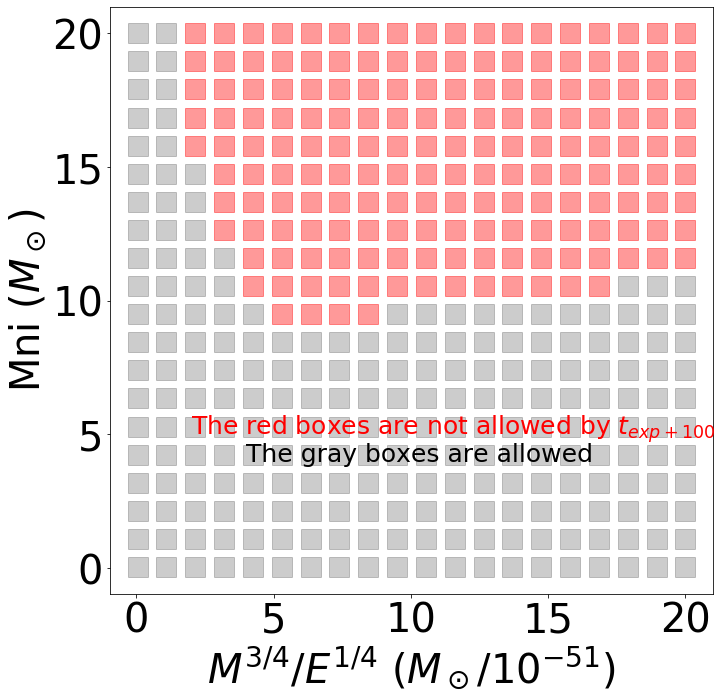

In [10]:
#for t+100

fig = plt.figure(figsize=(10.80,10.80))
plt.rcParams.update({'font.size': 40})
file_in = 'Nickel2_100.csv'
data_plot = ascii.read(file_in)

mni = data_plot['Mni']
mej = data_plot['Mekej']

#plt.figure()

for i in range(len(data_plot)):
    if data_plot['RuledOut'][i] == 'True':
        plt.plot(mej[i],mni[i],'rs', alpha=0.4, markersize = 20)

    else:
        plt.plot(mej[i],mni[i],'ks',alpha = 0.2, ms=20)#,alpha=0.2

plt.text(2,5,r'The red boxes are not allowed by $t_{exp + 100}$', color = 'r',fontsize =25)
plt.text(4,4,'The gray boxes are allowed', color = 'k',fontsize =25)

plt.xlabel(r'$M^{3/4}/E^{1/4}$ (${M}_\odot$/$10^{-51}$)',fontsize =40)
plt.ylabel(r'Mni (${M}_\odot$)',fontsize =40)
plt.tick_params(labelsize=40)
#plt.legend(fontsize =20)
fig.savefig('mni-mej100.png',dpi = 300, transparent = True)

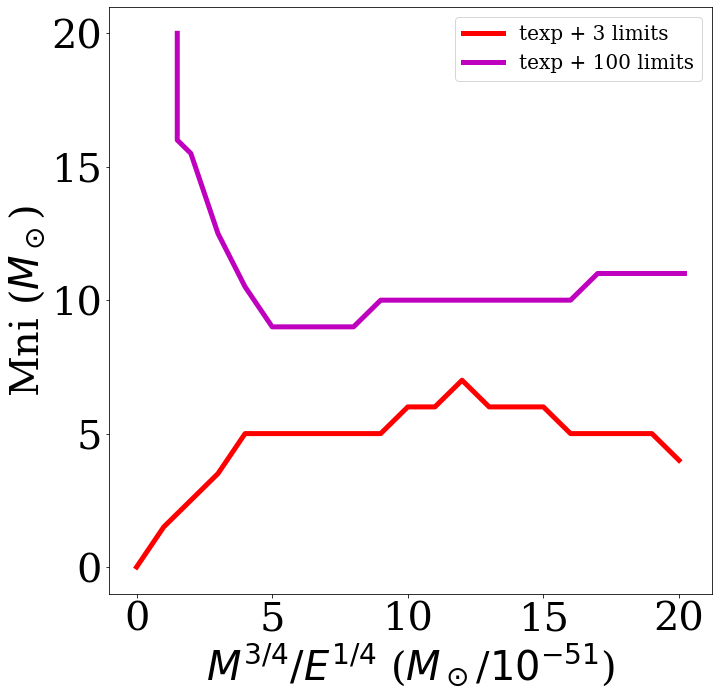

In [61]:
fig = plt.figure(figsize=(10.80,10.80))
plt.rcParams.update({'font.size': 40})
file_in1 = 'Nickel2a.csv'
data_plot1 = ascii.read(file_in1)
mni1 = data_plot1['Mni']
mej1 = data_plot1['Mekej']

file_in2 = 'Nickel2_100.csv'
data_plot2 = ascii.read(file_in2)
mni2 = data_plot2['Mni']
mej2 = data_plot2['Mekej']
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
y = [0,1.5,2.5,3.5,5,5,5,5,5,5,6,6,7,6,6,6,5,5,5,5,4]
a = [1.5,1.5,1.5,1.5,1.5,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,20.2]
b = [20,19,18,17,16,15.5,12.5,10.5,9,9,9,9,10,10,10,10,10,10,10,10,11,11,11,11,11]

for i in range(len(data_plot1)):
    if data_plot1['RuledOut'][i] == 'True':
        plt.plot(mej1[i],mni1[i],'r', alpha=0.2,ms = 20)
    else:
        plt.plot(mej1[i],mni1[i],'k',alpha=0.4, ms=20)#,alpha=0.2
for i in range(len(data_plot2)):
    if data_plot2['RuledOut'][i] == 'True':
        plt.plot(mej2[i],mni2[i],'m', alpha=0.3, markersize = 20)
    else:
        plt.plot(mej2[i],mni2[i],'c',alpha = 0.4, ms=20)
plt.plot(x,y,'r',linewidth = 5, label = 'texp + 3 limits')
plt.plot(a,b,'m', linewidth =5, label = 'texp + 100 limits')
plt.xlabel(r'$M^{3/4}/E^{1/4}$ (${M}_\odot$/$10^{-51}$)',fontsize =40)
plt.ylabel(r'Mni (${M}_\odot$)',fontsize =40)
plt.tick_params(labelsize=40)
plt.legend(fontsize =20)
plt.show()
        

Energy is in ergs (g⋅cm2/s2),
mass is in g
g^(3/4)  / (g⋅cm2/s2)^(1/4)

/home/ibik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
/home/ibik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in multiply
/home/ibik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp
/home/ibik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in multiply
/home/ibik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp
/home/ibik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


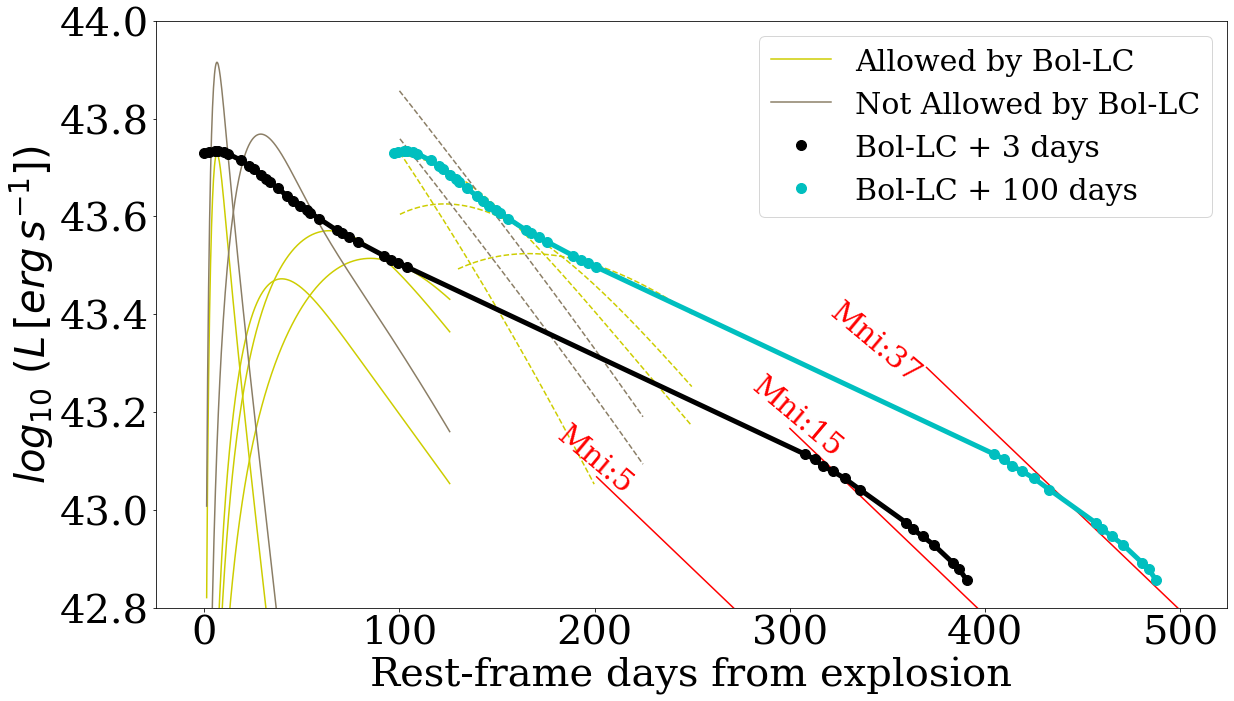

In [20]:
plt.figure(figsize=(19.20,10.80))
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 40})
#plt.plot(time/86400.,np.log10(lum))#label = 'Nickel only')
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t']
luma = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
t100 = data1['t100']

#plot the bolometric LCs
plt.errorbar(t,np.log10(luma),fmt = 'ko',ms =10,label = 'Bol-LC + 3 days')
plt.errorbar(t,np.log10(luma),fmt='k', ms =10,linewidth = 5)
plt.errorbar(t100,np.log10(luma),fmt = 'co',ms =10,label = 'Bol-LC + 100 days', linewidth = 5)
plt.errorbar(t100,np.log10(luma), fmt='c',ms =10, linewidth = 5)

#late time fulltrap
dt_a, Lum_a  = ValentiNebFit(37,180,100,fulltrap=True)
dt_b, Lum_b  = ValentiNebFit(15,180,100,fulltrap=True)
dt_c, Lum_c  = ValentiNebFit(5,180,1,fulltrap=True)

#Call function for t0+3
time1, lum1  = ArnettFit(5.3,8,1)
time2, lum2  = ArnettFit(5,6,1)
time3, lum3  = ArnettFit(3,4,1)
time4, lum4  = ArnettFit(1.3,0.5,1)
time5, lum5  = ArnettFit(4.7,3,1)
time6, lum6  = ArnettFit(2,0.5,1)
#Call function for t0+100
time1a, lum1a  = ArnettFit(9.7,9.5,100)
time2a, lum2a  = ArnettFit(11.5,3.2,100)
time3a, lum3a  = ArnettFit(10.9,18.95,100)
time4a, lum4a  = ArnettFit(9.5,12.5,100)
time5a, lum5a  = ArnettFit(12.5,5,100)
time6a, lum6a  = ArnettFit(10,5,100)

#plot early t0+3
plt.plot((time1/86400)[1:500], (np.log10(lum1))[1:500],'#CDCD00',label ='Allowed by Bol-LC')
plt.plot((time2/86400)[1:500], (np.log10(lum2))[1:500],'#CDCD00',)
plt.plot((time3/86400)[1:500], (np.log10(lum3))[1:500],'#CDCD00')
plt.plot((time4/86400)[1:500], (np.log10(lum4))[1:500],'#CDCD00')
plt.plot((time5/86400)[1:500], (np.log10(lum5))[1:500],'#8B7E66',label ='Not Allowed by Bol-LC')
plt.plot((time6/86400)[1:500], (np.log10(lum6))[1:500],'#8B7E66')
#plot early t0+100
plt.plot((time1a/86400)[1:600], (np.log10(lum1a))[1:600],'#CDCD00',linestyle ='--')
plt.plot((time2a/86400)[1:400], (np.log10(lum2a))[1:400],'#CDCD00',linestyle ='--')
plt.plot((time3a/86400)[120:600], (np.log10(lum3a))[120:600],'#CDCD00',linestyle ='--')
plt.plot((time4a/86400)[1:600], (np.log10(lum4a))[1:600],'#CDCD00',linestyle ='--')
plt.plot((time5a/86400)[:500], (np.log10(lum5a))[:500],'#8B7E66',linestyle ='--')
plt.plot((time6a/86400)[1:500], (np.log10(lum6a))[1:500],'#8B7E66',linestyle ='--')

#plot late t100 and t0 just to avoid going out and using the TTC
plt.plot(dt_a[270:],np.log10(Lum_a)[270:],'r')
plt.plot(dt_b[200:300],np.log10(Lum_b)[200:300],'r')
plt.plot(dt_c[200:498],np.log10(Lum_c)[200:498],'r')

#add the texts to specify the LC
#plt.text(340,42.95,'Mni:14',fontsize =12,ha='left', rotation=-40, wrap=True)
plt.text(280,43.25,'Mni:15',color = 'r',fontsize =30,ha='left', rotation=-40, wrap=True)
#plt.text(370,42.95,'Mni:17',fontsize =12,ha='left', rotation=-40, wrap=True)

#plt.text(315,43.45,'Mni:35',fontsize =12,ha='left', rotation=-40, wrap=True)
plt.text(320,43.40,'Mni:37',color = 'r', fontsize =30,ha='left', rotation=-40, wrap=True)
plt.text(180,43.15,'Mni:5',color = 'r',fontsize =30,ha='left', rotation=-40, wrap=True)

plt.ylim(42.8,44)
plt.tick_params(labelsize=40)
plt.xlabel('Rest-frame days from explosion',fontsize =40)
plt.ylabel(r'$log_{10}$ $(\mathit{L} \,[erg\,s^{-1}])$', fontsize =40)
plt.legend(fontsize =30)
#plt.show()
#plt.savefig('nickel_0.pdf')
plt.savefig('NimEjLC.png',dpi = 300, transparent = True)

In [129]:
#np.savetxt('nickel2.csv',data, delimiter = ',')
print(M_N)

15.0


In [128]:
#print(data) 
np.shape(mekej)
#print(lum)

(400,)

[   86400.   108000.   129600. ... 26114400. 26136000. 26157600.] [3.43811329e+40 5.28930577e+40 7.49964737e+40 ... 4.29442262e+41
 4.27915439e+41 4.26393679e+41]


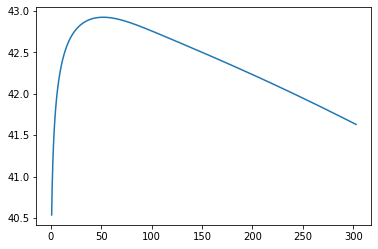

In [12]:
time, lum  = ArnettFit(1,5)
print(time, lum)
plt.plot(time/86400,np.log10(lum))
plt.show()


In [333]:
z = (time, lum)
np.savetxt('ni4a.csv',np.transpose(z), delimiter = ',')

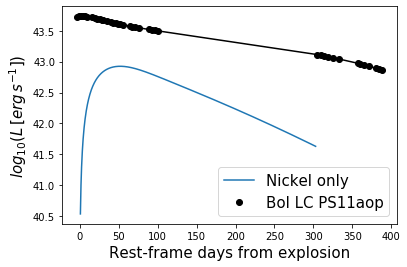

In [331]:
plt.plot(time/86400.,np.log10(lum),label = 'Nickel only')
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t']
lum = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(lum),fmt = 'ko',label = 'Bol LC PS11aop')
plt.errorbar(t,np.log10(lum),fmt = 'k')

#plt.legend()
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
plt.show()

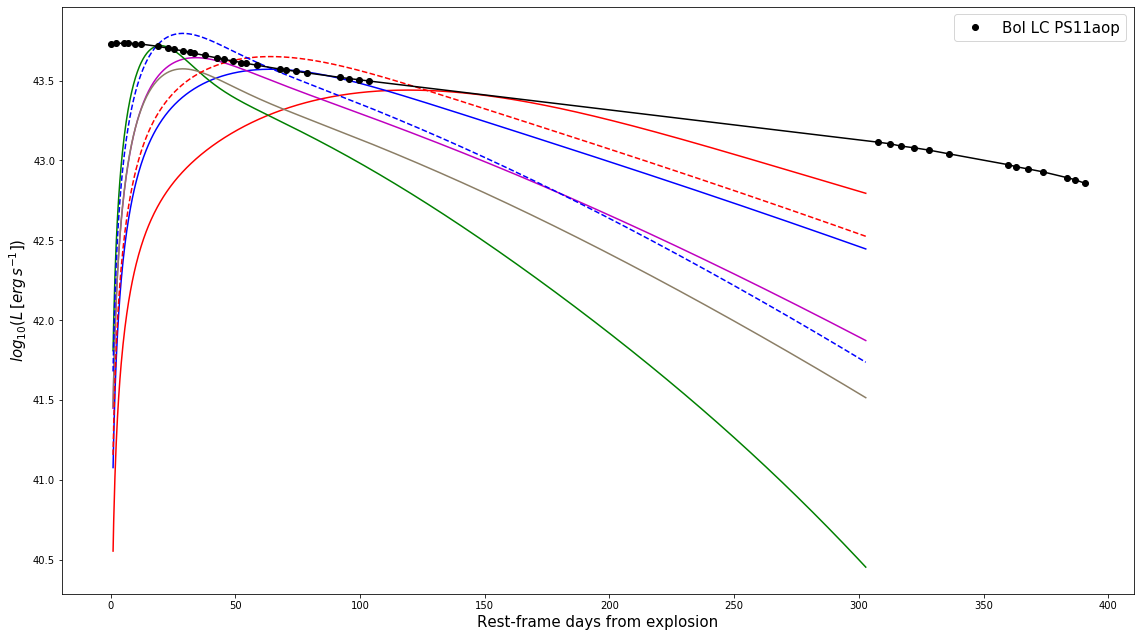

In [6]:
plt.figure(figsize=(19.20,10.80))
#plt.plot(time/86400.,np.log10(lum))#label = 'Nickel only')
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t']
luma = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(luma),fmt = 'ko',label = 'Bol LC PS11aop')
plt.errorbar(t,np.log10(luma),fmt = 'k')

file2='ni9.csv'
data2 = ascii.read(file2,format='csv')
time_9 = data2['time_9']/86400.
lum_9 = np.log10(data2['lum_9'])

file3='ni8.csv'
data3 = ascii.read(file3,format='csv')
time_8 = data3['time_8']/86400.
lum_8 = np.log10(data3['lum_8'])

file4='ni7.csv'
data4 = ascii.read(file4,format='csv')
time_7 = data4['time_7']/86400.
lum_7 = np.log10(data4['lum_7'])
file5='ni.csv'
data5 = ascii.read(file5,format='csv')
time = data5['time']/86400.
lum = np.log10(data5['lum'])
file6='ni2.csv'
data6 = ascii.read(file6,format='csv')
time_2 = data6['time_2']/86400.
lum_2 = np.log10(data6['lum_2'])
file7='ni3.csv'
data7 = ascii.read(file7,format='csv')
time_3 = data7['time_3']/86400.
lum_3 = np.log10(data7['lum_3'])
file7='ni4a.csv'
data7 = ascii.read(file7,format='csv')
time_4a = data7['time_4a']/86400.
lum_4a = np.log10(data7['lum_4a'])
file7='ni2a.csv'
data7 = ascii.read(file7,format='csv')
time_2a = data7['time_2a']/86400.
lum_2a = np.log10(data7['lum_2a'])
file8='ni9a.csv'
data8 = ascii.read(file8,format='csv')
time_9a = data8['time_9a']/86400.
lum_9a = np.log10(data8['lum_9a'])
file9='ni8a.csv'
data9 = ascii.read(file9,format='csv')
time_8a = data9['time_8a']/86400.
lum_8a = np.log10(data9['lum_8a'])



#plt.plot(time_9,lum_9,'r',time_8 ,lum_8,'b',time_7,lum_7,'c',time, lum,'m',time_2,lum_2,'g',time_4a, lum_4a,'#CDCD00',time_2a, lum_2a,'#8B7E66',time_9a,lum_9a,'r--',time_8a ,lum_8a,'b--')
#plt.legend()
plt.plot(time_9,lum_9,'r',time_8 ,lum_8,'b',time, lum,'m',time_2,lum_2,'g',time_2a, lum_2a,'#8B7E66',time_9a,lum_9a,'r--',time_8a ,lum_8a,'b--')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10} (\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
#plt.show()
plt.savefig('nickel.pdf')

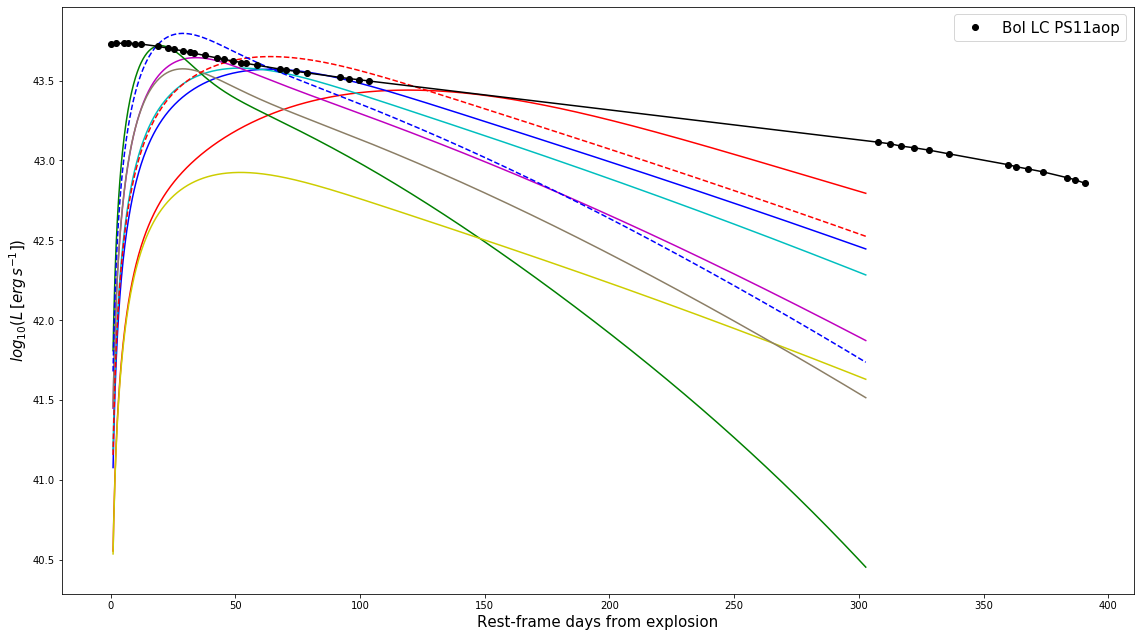

In [365]:
plt.figure(figsize=(19.20,10.80))
#plt.plot(time/86400.,np.log10(lum))#label = 'Nickel only')
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t']
luma = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(luma),fmt = 'ko',label = 'Bol LC PS11aop')
plt.errorbar(t,np.log10(luma),fmt = 'k')

file2='ni9.csv'
data2 = ascii.read(file2,format='csv')
time_9 = data2['time_9']/86400.
lum_9 = np.log10(data2['lum_9'])

file3='ni8.csv'
data3 = ascii.read(file3,format='csv')
time_8 = data3['time_8']/86400.
lum_8 = np.log10(data3['lum_8'])

file4='ni7.csv'
data4 = ascii.read(file4,format='csv')
time_7 = data4['time_7']/86400.
lum_7 = np.log10(data4['lum_7'])
file5='ni.csv'
data5 = ascii.read(file5,format='csv')
time = data5['time']/86400.
lum = np.log10(data5['lum'])
file6='ni2.csv'
data6 = ascii.read(file6,format='csv')
time_2 = data6['time_2']/86400.
lum_2 = np.log10(data6['lum_2'])
file7='ni3.csv'
data7 = ascii.read(file7,format='csv')
time_3 = data7['time_3']/86400.
lum_3 = np.log10(data7['lum_3'])
file7='ni4a.csv'
data7 = ascii.read(file7,format='csv')
time_4a = data7['time_4a']/86400.
lum_4a = np.log10(data7['lum_4a'])
file7='ni2a.csv'
data7 = ascii.read(file7,format='csv')
time_2a = data7['time_2a']/86400.
lum_2a = np.log10(data7['lum_2a'])
file8='ni9a.csv'
data8 = ascii.read(file8,format='csv')
time_9a = data8['time_9a']/86400.
lum_9a = np.log10(data8['lum_9a'])
file9='ni8a.csv'
data9 = ascii.read(file9,format='csv')
time_8a = data9['time_8a']/86400.
lum_8a = np.log10(data9['lum_8a'])




#plt.legend()
plt.plot(time_9,lum_9,'r',time_8 ,lum_8,'b',time_7,lum_7,'c',time, lum,'m',time_2,lum_2,'g',time_4a, lum_4a,'#CDCD00',time_2a, lum_2a,'#8B7E66',time_9a,lum_9a,'r--',time_8a ,lum_8a,'b--')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
#plt.show()
plt.savefig('nickel_0.pdf')

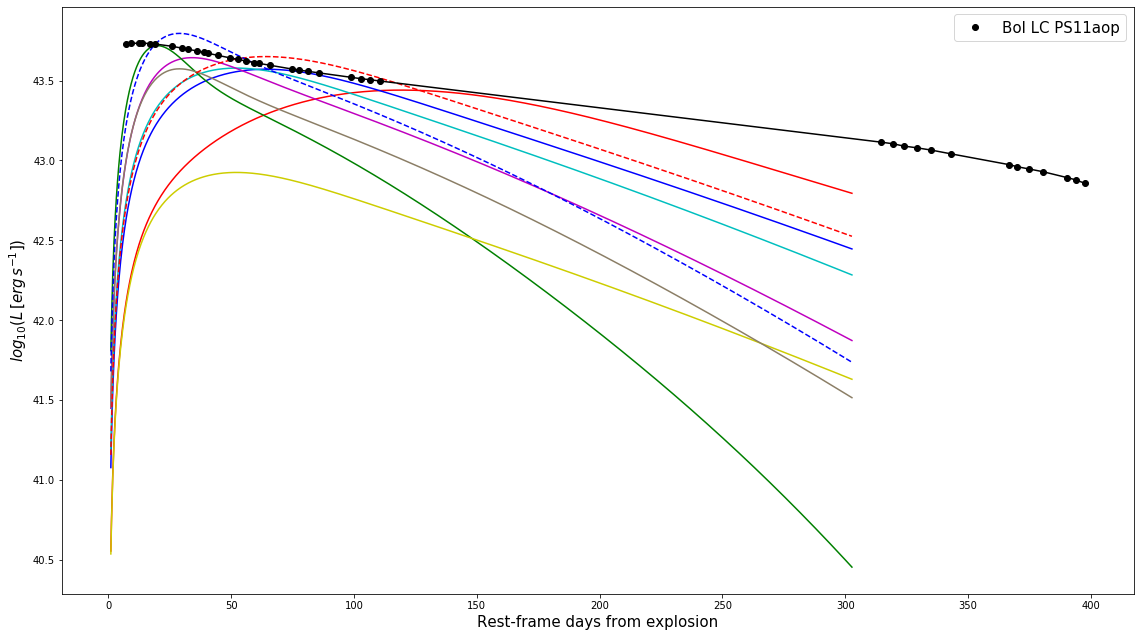

In [366]:
plt.figure(figsize=(19.20,10.80))
#plt.plot(time/86400.,np.log10(lum))#label = 'Nickel only')
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t1']
luma = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(luma),fmt = 'ko',label = 'Bol LC PS11aop')
plt.errorbar(t,np.log10(luma),fmt = 'k')

file2='ni9.csv'
data2 = ascii.read(file2,format='csv')
time_9 = data2['time_9']/86400.
lum_9 = np.log10(data2['lum_9'])

file3='ni8.csv'
data3 = ascii.read(file3,format='csv')
time_8 = data3['time_8']/86400.
lum_8 = np.log10(data3['lum_8'])

file4='ni7.csv'
data4 = ascii.read(file4,format='csv')
time_7 = data4['time_7']/86400.
lum_7 = np.log10(data4['lum_7'])
file5='ni.csv'
data5 = ascii.read(file5,format='csv')
time = data5['time']/86400.
lum = np.log10(data5['lum'])
file6='ni2.csv'
data6 = ascii.read(file6,format='csv')
time_2 = data6['time_2']/86400.
lum_2 = np.log10(data6['lum_2'])
file7='ni3.csv'
data7 = ascii.read(file7,format='csv')
time_3 = data7['time_3']/86400.
lum_3 = np.log10(data7['lum_3'])
file7='ni4a.csv'
data7 = ascii.read(file7,format='csv')
time_4a = data7['time_4a']/86400.
lum_4a = np.log10(data7['lum_4a'])
file7='ni2a.csv'
data7 = ascii.read(file7,format='csv')
time_2a = data7['time_2a']/86400.
lum_2a = np.log10(data7['lum_2a'])
file8='ni9a.csv'
data8 = ascii.read(file8,format='csv')
time_9a = data8['time_9a']/86400.
lum_9a = np.log10(data8['lum_9a'])
file9='ni8a.csv'
data9 = ascii.read(file9,format='csv')
time_8a = data9['time_8a']/86400.
lum_8a = np.log10(data9['lum_8a'])




#plt.legend()
plt.plot(time_9,lum_9,'r',time_8 ,lum_8,'b',time_7,lum_7,'c',time, lum,'m',time_2,lum_2,'g',time_4a, lum_4a,'#CDCD00',time_2a, lum_2a,'#8B7E66',time_9a,lum_9a,'r--',time_8a ,lum_8a,'b--')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
#plt.show()
plt.savefig('nickel_1.pdf')

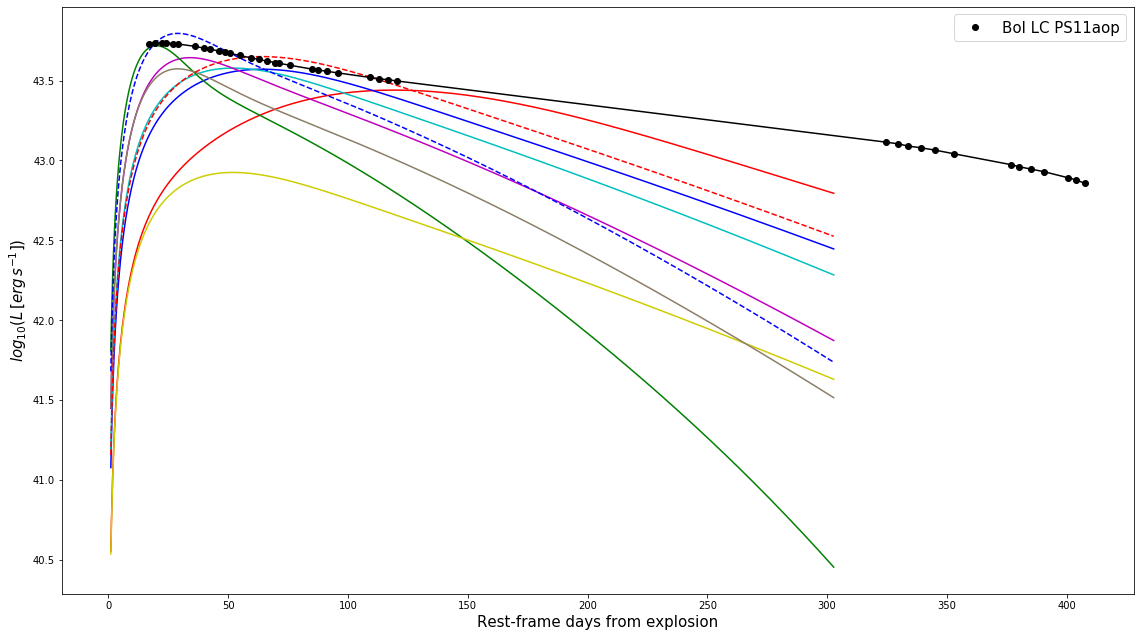

In [367]:
plt.figure(figsize=(19.20,10.80))
#plt.plot(time/86400.,np.log10(lum))#label = 'Nickel only')
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t2']
luma = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(luma),fmt = 'ko',label = 'Bol LC PS11aop')
plt.errorbar(t,np.log10(luma),fmt = 'k')

file2='ni9.csv'
data2 = ascii.read(file2,format='csv')
time_9 = data2['time_9']/86400.
lum_9 = np.log10(data2['lum_9'])

file3='ni8.csv'
data3 = ascii.read(file3,format='csv')
time_8 = data3['time_8']/86400.
lum_8 = np.log10(data3['lum_8'])

file4='ni7.csv'
data4 = ascii.read(file4,format='csv')
time_7 = data4['time_7']/86400.
lum_7 = np.log10(data4['lum_7'])
file5='ni.csv'
data5 = ascii.read(file5,format='csv')
time = data5['time']/86400.
lum = np.log10(data5['lum'])
file6='ni2.csv'
data6 = ascii.read(file6,format='csv')
time_2 = data6['time_2']/86400.
lum_2 = np.log10(data6['lum_2'])
file7='ni3.csv'
data7 = ascii.read(file7,format='csv')
time_3 = data7['time_3']/86400.
lum_3 = np.log10(data7['lum_3'])
file7='ni4a.csv'
data7 = ascii.read(file7,format='csv')
time_4a = data7['time_4a']/86400.
lum_4a = np.log10(data7['lum_4a'])
file7='ni2a.csv'
data7 = ascii.read(file7,format='csv')
time_2a = data7['time_2a']/86400.
lum_2a = np.log10(data7['lum_2a'])
file8='ni9a.csv'
data8 = ascii.read(file8,format='csv')
time_9a = data8['time_9a']/86400.
lum_9a = np.log10(data8['lum_9a'])
file9='ni8a.csv'
data9 = ascii.read(file9,format='csv')
time_8a = data9['time_8a']/86400.
lum_8a = np.log10(data9['lum_8a'])




#plt.legend()
plt.plot(time_9,lum_9,'r',time_8 ,lum_8,'b',time_7,lum_7,'c',time, lum,'m',time_2,lum_2,'g',time_4a, lum_4a,'#CDCD00',time_2a, lum_2a,'#8B7E66',time_9a,lum_9a,'r--',time_8a ,lum_8a,'b--')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
#plt.show()
plt.savefig('nickel_2.pdf')

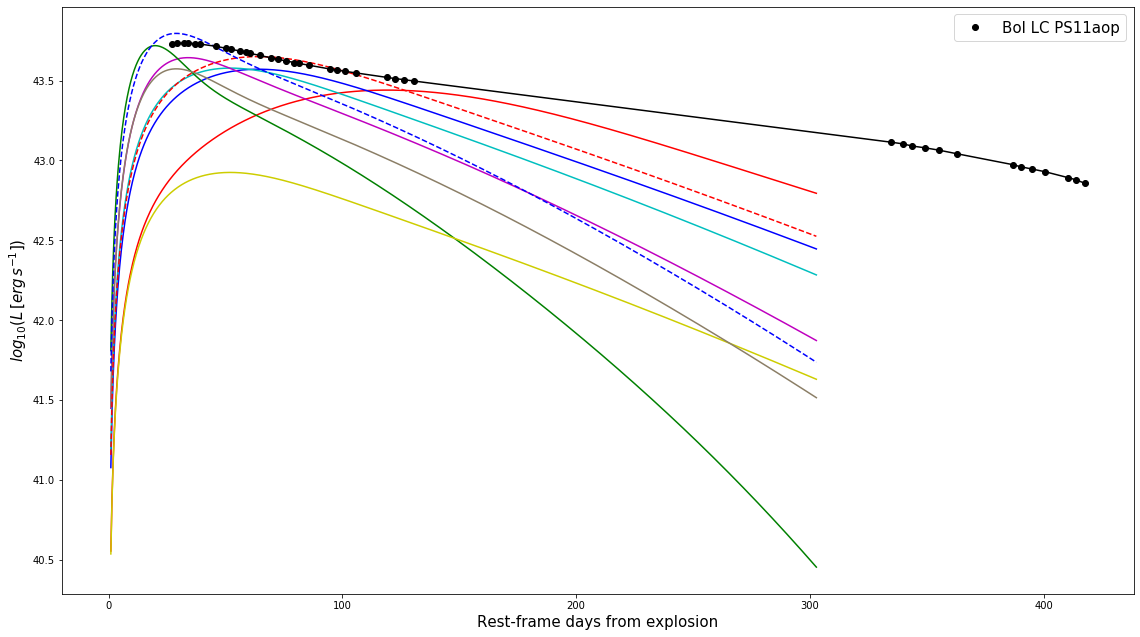

In [368]:
plt.figure(figsize=(19.20,10.80))
#plt.plot(time/86400.,np.log10(lum))#label = 'Nickel only')
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t3']
luma = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(luma),fmt = 'ko',label = 'Bol LC PS11aop')
plt.errorbar(t,np.log10(luma),fmt = 'k')

file2='ni9.csv'
data2 = ascii.read(file2,format='csv')
time_9 = data2['time_9']/86400.
lum_9 = np.log10(data2['lum_9'])

file3='ni8.csv'
data3 = ascii.read(file3,format='csv')
time_8 = data3['time_8']/86400.
lum_8 = np.log10(data3['lum_8'])

file4='ni7.csv'
data4 = ascii.read(file4,format='csv')
time_7 = data4['time_7']/86400.
lum_7 = np.log10(data4['lum_7'])
file5='ni.csv'
data5 = ascii.read(file5,format='csv')
time = data5['time']/86400.
lum = np.log10(data5['lum'])
file6='ni2.csv'
data6 = ascii.read(file6,format='csv')
time_2 = data6['time_2']/86400.
lum_2 = np.log10(data6['lum_2'])
file7='ni3.csv'
data7 = ascii.read(file7,format='csv')
time_3 = data7['time_3']/86400.
lum_3 = np.log10(data7['lum_3'])
file7='ni4a.csv'
data7 = ascii.read(file7,format='csv')
time_4a = data7['time_4a']/86400.
lum_4a = np.log10(data7['lum_4a'])
file7='ni2a.csv'
data7 = ascii.read(file7,format='csv')
time_2a = data7['time_2a']/86400.
lum_2a = np.log10(data7['lum_2a'])
file8='ni9a.csv'
data8 = ascii.read(file8,format='csv')
time_9a = data8['time_9a']/86400.
lum_9a = np.log10(data8['lum_9a'])
file9='ni8a.csv'
data9 = ascii.read(file9,format='csv')
time_8a = data9['time_8a']/86400.
lum_8a = np.log10(data9['lum_8a'])




#plt.legend()
plt.plot(time_9,lum_9,'r',time_8 ,lum_8,'b',time_7,lum_7,'c',time, lum,'m',time_2,lum_2,'g',time_4a, lum_4a,'#CDCD00',time_2a, lum_2a,'#8B7E66',time_9a,lum_9a,'r--',time_8a ,lum_8a,'b--')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
#plt.show()
plt.savefig('nickel_3.pdf')

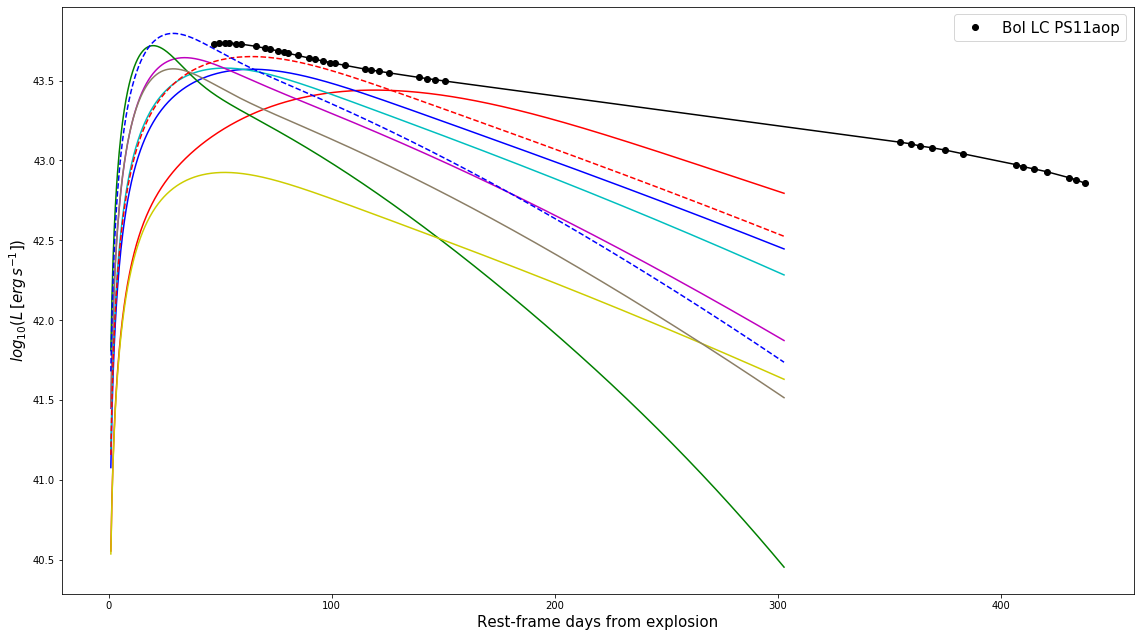

In [369]:
plt.figure(figsize=(19.20,10.80))
#plt.plot(time/86400.,np.log10(lum))#label = 'Nickel only')
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t4']
luma = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(luma),fmt = 'ko',label = 'Bol LC PS11aop')
plt.errorbar(t,np.log10(luma),fmt = 'k')

file2='ni9.csv'
data2 = ascii.read(file2,format='csv')
time_9 = data2['time_9']/86400.
lum_9 = np.log10(data2['lum_9'])

file3='ni8.csv'
data3 = ascii.read(file3,format='csv')
time_8 = data3['time_8']/86400.
lum_8 = np.log10(data3['lum_8'])

file4='ni7.csv'
data4 = ascii.read(file4,format='csv')
time_7 = data4['time_7']/86400.
lum_7 = np.log10(data4['lum_7'])
file5='ni.csv'
data5 = ascii.read(file5,format='csv')
time = data5['time']/86400.
lum = np.log10(data5['lum'])
file6='ni2.csv'
data6 = ascii.read(file6,format='csv')
time_2 = data6['time_2']/86400.
lum_2 = np.log10(data6['lum_2'])
file7='ni3.csv'
data7 = ascii.read(file7,format='csv')
time_3 = data7['time_3']/86400.
lum_3 = np.log10(data7['lum_3'])
file7='ni4a.csv'
data7 = ascii.read(file7,format='csv')
time_4a = data7['time_4a']/86400.
lum_4a = np.log10(data7['lum_4a'])
file7='ni2a.csv'
data7 = ascii.read(file7,format='csv')
time_2a = data7['time_2a']/86400.
lum_2a = np.log10(data7['lum_2a'])
file8='ni9a.csv'
data8 = ascii.read(file8,format='csv')
time_9a = data8['time_9a']/86400.
lum_9a = np.log10(data8['lum_9a'])
file9='ni8a.csv'
data9 = ascii.read(file9,format='csv')
time_8a = data9['time_8a']/86400.
lum_8a = np.log10(data9['lum_8a'])




#plt.legend()
plt.plot(time_9,lum_9,'r',time_8 ,lum_8,'b',time_7,lum_7,'c',time, lum,'m',time_2,lum_2,'g',time_4a, lum_4a,'#CDCD00',time_2a, lum_2a,'#8B7E66',time_9a,lum_9a,'r--',time_8a ,lum_8a,'b--')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
#plt.show()
plt.savefig('nickel_4.pdf')

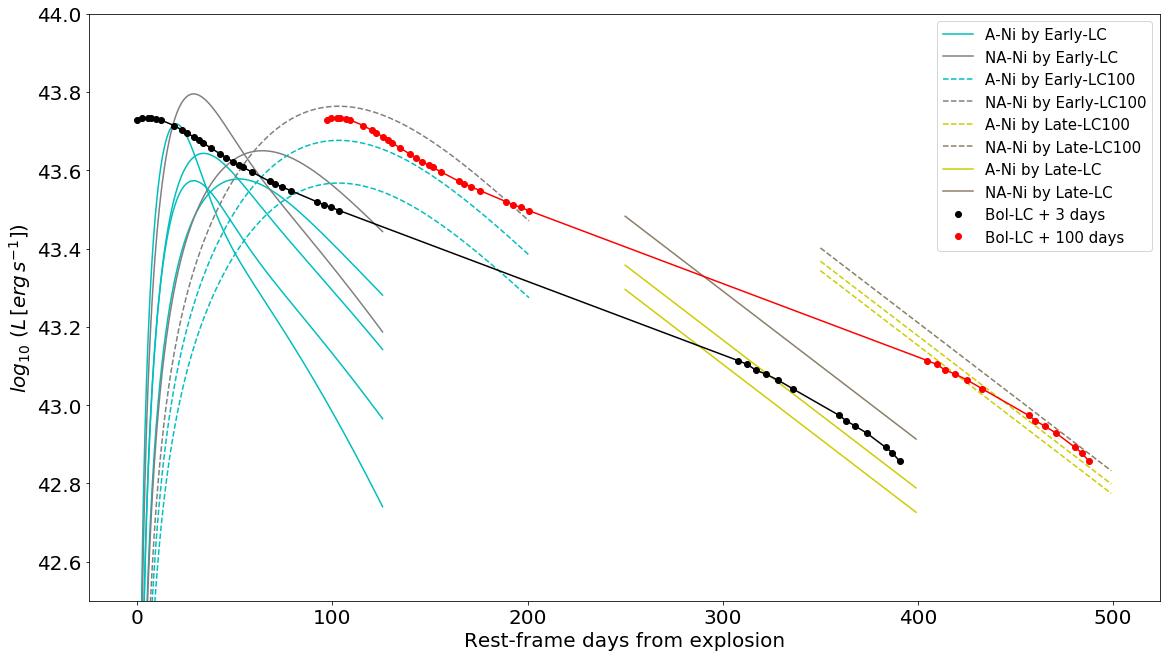

In [58]:
plt.figure(figsize=(19.20,10.80))
#plt.plot(time/86400.,np.log10(lum))#label = 'Nickel only')
file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t']
luma = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
t100 = data1['t100']
plt.errorbar(t,np.log10(luma),fmt = 'ko',label = 'Bol-LC + 3 days')
plt.errorbar(t,np.log10(luma),fmt='k')
plt.errorbar(t100,np.log10(luma),fmt = 'ro',label = 'Bol-LC + 100 days')
plt.errorbar(t100,np.log10(luma), fmt='r')

file4='ni7.csv'
data4 = ascii.read(file4,format='csv')
time_7 = data4['time_7']/86400.
lum_7 = np.log10(data4['lum_7'])
file5='ni.csv'
data5 = ascii.read(file5,format='csv')
time = data5['time']/86400.
lum = np.log10(data5['lum'])
file6='ni2.csv'
data6 = ascii.read(file6,format='csv')
time_2 = data6['time_2']/86400.
lum_2 = np.log10(data6['lum_2'])
file7='ni3.csv'
data7 = ascii.read(file7,format='csv')
time_3 = data7['time_3']/86400.
lum_3 = np.log10(data7['lum_3'])
file7='ni4a.csv'
data7 = ascii.read(file7,format='csv')
time_4a = data7['time_4a']/86400.
lum_4a = np.log10(data7['lum_4a'])
file7='ni2a.csv'
data7 = ascii.read(file7,format='csv')
time_2a = data7['time_2a']/86400.
lum_2a = np.log10(data7['lum_2a'])
file8='ni9a.csv'
data8 = ascii.read(file8,format='csv')
time_9a = data8['time_9a']/86400.
lum_9a = np.log10(data8['lum_9a'])
file9='ni8a.csv'
data9 = ascii.read(file9,format='csv')
time_8a = data9['time_8a']/86400.
lum_8a = np.log10(data9['lum_8a'])

file_st='ni7and10.csv'
datast = ascii.read(file_st,format='csv')
time_st = datast['time_st']/86400.
lum_st = np.log10(datast['lum_st'])
file_nt='ni9and10.csv'
datant = ascii.read(file_nt,format='csv')
time_nt = datant['time_nt']/86400.
lum_nt = np.log10(datant['lum_nt'])
file_et='ni11and10.csv'
dataet = ascii.read(file_et,format='csv')
time_et = dataet['time_et']/86400.
lum_et = np.log10(dataet['lum_et'])

file_lt='nifulltrapa.csv'
data_lt = ascii.read(file_lt,format='csv')
time_lt = data_lt['time_lt']
lum_lt = np.log10(data_lt['lum_lt'])
time_lt2 = data_lt['time_lt2']
lum_lt2 = np.log10(data_lt['lum_lt2'])
time_lt3 = data_lt['time_lt3']
lum_lt3 = np.log10(data_lt['lum_lt3'])
time_lt0 = data_lt['time_lt0']
lum_lt0 = np.log10(data_lt['lum_lt0'])
time_lt20 = data_lt['time_lt20']
lum_lt20 = np.log10(data_lt['lum_lt20'])
time_lt30 = data_lt['time_lt30']
lum_lt30 = np.log10(data_lt['lum_lt30'])



#plt.legend()

plt.plot(time_7[:500],lum_7[:500],'c',time[:500], lum[:500],'c',time_2[:500],lum_2[:500],'c',time_9a[:500],lum_9a[:500],'gray')
plt.plot(time_2a[:500], lum_2a[:500],'c',label ='A-Ni by Early-LC')
plt.plot(time_8a[:500] ,lum_8a[:500],'gray',label ='NA-Ni by Early-LC')
plt.plot(time_st[:800],lum_st[:800],'c--')
plt.plot(time_nt[:800], lum_nt[:800],'c--',label ='A-Ni by Early-LC100')
plt.plot(time_et[:800],lum_et[:800],'gray',linestyle ='--',label ='NA-Ni by Early-LC100')
plt.plot(time_lt[250:],lum_lt[250:],'#CDCD00',linestyle ='--',label ='A-Ni by Late-LC100')
plt.plot(time_lt2[250:],lum_lt2[250:],'#CDCD00',linestyle ='--')
plt.plot(time_lt3[250:],lum_lt3[250:],'#8B7E66',linestyle ='--',label ='NA-Ni by Late-LC100')

plt.plot(time_lt0[150:300],lum_lt0[150:300],'#CDCD00',label ='A-Ni by Late-LC')
plt.plot(time_lt20[150:300],lum_lt20[150:300],'#CDCD00')
plt.plot(time_lt30[150:300],lum_lt30[150:300],'#8B7E66',label ='NA-Ni by Late-LC')
plt.ylim(42.5,44)
plt.tick_params(labelsize=20)
plt.xlabel('Rest-frame days from explosion',fontsize =20)
plt.ylabel(r'$log_{10}$ $(\mathit{L} \,[erg\,s^{-1}])$', fontsize =20)
plt.legend(fontsize =15)
plt.show()
#plt.savefig('nickel_0.pdf')